Downloading and importing the dependencies

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Visualization Utilities

In [ ]:
model = "/content/pose_landmarker.task"

In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

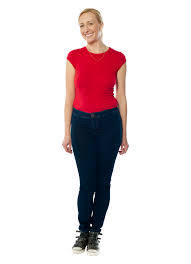

In [ ]:
# Test image
img = cv2.imread("/content/sample_data/female.jpg")
cv2_imshow(img)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


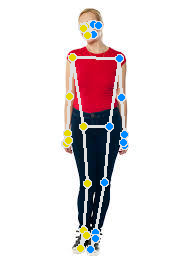

In [ ]:
# Marking pose landmarkers

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/sample_data/female.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Extracting the landmark coordinates

In [ ]:
# Dictionary to store landmark details
landmark_details = {}

# Dictionary to map landmark indices to labels
landmark_labels = {
    12: 'Left shoulder',
    13: 'Right shoulder',
    14: 'Left elbow',
    15: 'Right elbow',
    16: 'Left wrist',
    17: 'Right wrist',
    24: 'Left hip',
    25: 'Right hip',
    26: 'Left knee',
    27: 'Right knee',
    28: 'Left ankle',
    29: 'Right ankle'
}

for i, landmarks_list in enumerate(detection_result.pose_landmarks):
    for j, landmark in enumerate(landmarks_list):
        if j + 1 in landmark_labels:
            label = landmark_labels[j + 1]
            landmark_list = [landmark.x, landmark.y]
            # landmark_list = [landmark.x * 100, landmark.y * 100, landmark.z * 100, landmark.visibility, landmark.presence]
            landmark_details[label] = landmark_list

In [ ]:
for key, value in landmark_details.items():
    print(key, value, sep=": ")

Left shoulder: [0.6265462040901184, 0.22041693329811096]
Right shoulder: [0.38176700472831726, 0.21654734015464783]
Left elbow: [0.6370898485183716, 0.36790451407432556]
Right elbow: [0.3643375039100647, 0.36520031094551086]
Left wrist: [0.6540425419807434, 0.5105399489402771]
Right wrist: [0.3531608283519745, 0.504261314868927]
Left hip: [0.5744627714157104, 0.47792285680770874]
Right hip: [0.43565845489501953, 0.47891494631767273]
Left knee: [0.5458147525787354, 0.6923115849494934]
Right knee: [0.4569801092147827, 0.6942554116249084]
Left ankle: [0.502470076084137, 0.8804640769958496]
Right ankle: [0.4392811357975006, 0.8733706474304199]


Contour Mapping using canny edge detection

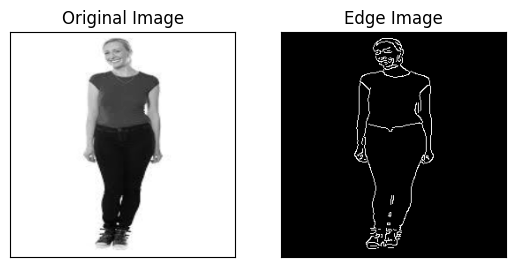

In [ ]:
# Canny edge detection using OpenCV

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('/content/sample_data/female.jpg', cv.IMREAD_GRAYSCALE)

# Resize the image to 256x256 dimensions
img = cv2.resize(img, (256, 256))

assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

Manipulating the numbers for measurements




In [ ]:
def calculate_midpoint(point1, point2, ratio):
    # Calculate the midpoint between two points
    x = point1[0] + (point2[0] - point1[0]) * ratio
    y = point1[1] + (point2[1] - point1[1]) * ratio
    return (x, y)

def create_division_points(landmark_details):
    # Extract the required points
    left_shoulder = landmark_details['Left shoulder']
    right_shoulder = landmark_details['Right shoulder']
    left_hip = landmark_details['Left hip']
    right_hip = landmark_details['Right hip']

    # Calculate the division points
    point1 = calculate_midpoint(left_shoulder, left_hip, 1/3)
    point2 = calculate_midpoint(right_shoulder, right_hip, 1/3)
    point3 = calculate_midpoint(left_shoulder, left_hip, 2/3)
    point4 = calculate_midpoint(right_shoulder, right_hip, 2/3)

    # Create the dictionary
    division_points = {
        'Left bust': point1,
        'Right bust': point2,
        'Left waist': point3,
        'Right waist': point4,
        'Left Hip': left_hip,
        'Right Hip': right_hip
    }
    return division_points

division_points = create_division_points(landmark_details)

In [ ]:
for key, value in division_points.items():
  print(f"{key}: {value}")

Left bust: (0.6091850598653158, 0.30625224113464355)
Right bust: (0.39973082145055133, 0.30400320887565613)
Left waist: (0.5918239156405131, 0.39208754897117615)
Right waist: (0.41769463817278546, 0.39145907759666443)
Left Hip: [0.5744627714157104, 0.47792285680770874]
Right Hip: [0.43565845489501953, 0.47891494631767273]


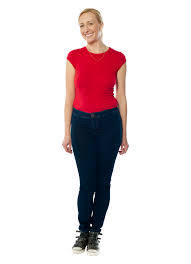

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read the image
img = cv2.imread('/content/sample_data/female.jpg', cv2.IMREAD_COLOR)

# left_shoulder = [0.5918239156405131, 0.39208754897117615]
# right_shoulder = [0.41769463817278546, 0.39145907759666443]

left_bust = [0.6091850598653158, 0.30625224113464355]
right_bust = [0.39973082145055133, 0.30400320887565613]
left_waist = [0.5918239156405131, 0.39208754897117615]
right_waist = [0.41769463817278546, 0.39145907759666443]
left_hip = [0.5744627714157104, 0.47792285680770874]
right_hip = [0.43565845489501953, 0.47891494631767273]

# Convert shoulder coordinates to image pixel coordinates
width, height = img.shape[1], img.shape[0]

# Convert normalized coordinates to pixel coordinates
left_bust_pixel = (int(left_bust[0] * width), int(left_bust[1] * height))
right_bust_pixel = (int(right_bust[0] * width), int(right_bust[1] * height))
left_waist_pixel = (int(left_waist[0] * width), int(left_waist[1] * height))
right_waist_pixel = (int(right_waist[0] * width), int(right_waist[1] * height))
left_hip_pixel = (int(left_hip[0] * width), int(left_hip[1] * height))
right_hip_pixel = (int(right_hip[0] * width), int(right_hip[1] * height))

edges = cv2.Canny(img, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over the contours
def left_boundary(left_pixel):
  for contour in contours:
      for x in range(left_pixel[0], 0, -1):
          if edges[left_pixel[1], x] > 0:
              left_boundary = (x, left_pixel[1])
              cv2.circle(img, left_boundary, 5, (0, 255, 0), -1)
              return left_boundary

    # Iterate over x-coordinates starting from the right shoulder
def right_boundary(right_pixel):
  for x in range(right_pixel[0], width):
      if edges[right_pixel[1], x] > 0:
          right_boundary = (x, right_pixel[1])
          cv2.circle(img, right_boundary, 5, (0, 255, 0), -1)
          return right_boundary

# Display the image with the marked coordinates
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# Final boundary points
boundary_points = {
        'Left bust boundary': left_boundary(left_bust_pixel),
        'Right bust boundary': right_boundary(right_bust_pixel),
        'Left waist boundary': left_boundary(left_waist_pixel),
        'Right waist boundary': right_boundary(right_waist_pixel),
        'Left Hip boundary': left_boundary(left_hip_pixel),
        'Right Hip boundary': right_boundary(right_hip_pixel)
    }

for key, value in boundary_points.items():
  print(f"{key}: {value}")

Left bust boundary: (115, 80)
Right bust boundary: (76, 80)
Left waist boundary: (73, 103)
Right waist boundary: (118, 103)
Left Hip boundary: (71, 126)
Right Hip boundary: (122, 126)


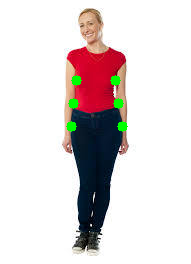

In [ ]:
# Display the image with the marked coordinates
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import numpy as np

def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Calculate the lengths
bust_length = euclidean_distance(boundary_points['Left bust boundary'], boundary_points['Right bust boundary'])
waist_length = euclidean_distance(boundary_points['Left waist boundary'], boundary_points['Right waist boundary'])
hip_length = euclidean_distance(boundary_points['Left Hip boundary'], boundary_points['Right Hip boundary'])

print("Bust length:", bust_length)
print("Waist length:", waist_length)
print("Hip length:", hip_length)


Bust length: 39.0
Waist length: 45.0
Hip length: 51.0
